# Demo File

## Data Generation

### Definition of Data Generation Functions

In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to generate donut-shaped data with an inner cluster
def make_donut_data(num_classes=2, num_samples=100, radius_delta=1):
    circle_all = np.array([])
    
    current_radius = radius_delta * num_classes

    for i in range(num_classes):
        theta = inner_theta = np.random.uniform(0, 2*np.pi, num_samples)

        # Donut data
        circle_x = current_radius * np.cos(theta)
        circle_y = current_radius * np.sin(theta)

        circle_indiv = np.array([circle_x, circle_y]).T
        circle_all = np.vstack((circle_all, circle_indiv)) if circle_all.size else circle_indiv

        current_radius = current_radius - radius_delta

        
    return circle_all

def make_sinusoidal_wave(amplitude=1, frequency=1.5, phase=0, num_samples=100, num_classes=2, y_difference = 2):
    # Generating x values
    x = np.linspace(0, 4 * np.pi, num_samples)

    x_all = np.array([])
    y_all = np.array([])
    diff = 0

    # Calculating the sinusoidal wave
    for i in range(num_classes):
        x_all = np.concatenate((x_all, [x]), axis=1) if x_all.size else np.array([x])

        y_indiv = amplitude * np.sin(frequency * x + phase) + diff
        y_all = np.concatenate((y_all, [y_indiv]), axis=1) if y_all.size else np.array([y_indiv])
        diff = diff + y_difference

    return np.vstack((x_all, y_all)).T

def make_pinwheel_data(num_samples=100, num_classes=2, radius=1, stddev=0):
    # Generating the data for the pinwheel
    angle = np.linspace(0, 2 * np.pi, num_samples)
    data = np.zeros((num_samples * num_classes, 2))
    for i in range(num_classes):
        ix = range(num_samples * i, num_samples * (i + 1))
        r = np.linspace(0.0, radius, num_samples) + np.random.normal(0, stddev, num_samples)
        data[ix] = np.c_[r * np.cos(angle + i * (2 * np.pi) / num_classes),
                         r * np.sin(angle + i * (2 * np.pi) / num_classes)]
    return data

def make_bar_data(num_samples=100, num_classes=2, x_init = 0.0, y = 0.5, distance_delta = 1):
    # Generating points for bars
    x = x_init
    bar_all = y_all = np.array([])
    
    for i in range(num_classes):
        bar_indiv = np.random.rand(num_samples, 2) * 0.5 + np.array([x, y])
        bar_all = np.vstack((bar_all, bar_indiv)) if bar_all.size else bar_indiv
        x = x + distance_delta

    return bar_all
     

### Generating the Data

In [198]:
#define the colors to be used in the plots
colors = ['red', 'orange', 'lime', 'green', 'blue', 'navy', 'violet']
fig_size = 6

# Params of Data Generation
samples = 100  # Number of samples per class
classes = 4     # Number of classes

# X = make_donut_data(num_classes=classes, num_samples=samples)
# X = make_sinusoidal_wave(num_samples=samples, num_classes=classes)
# X = make_pinwheel_data(num_samples=samples, num_classes=classes, stddev=0)
X = make_bar_data(num_samples=samples, num_classes=classes)


### Making the Data Plot

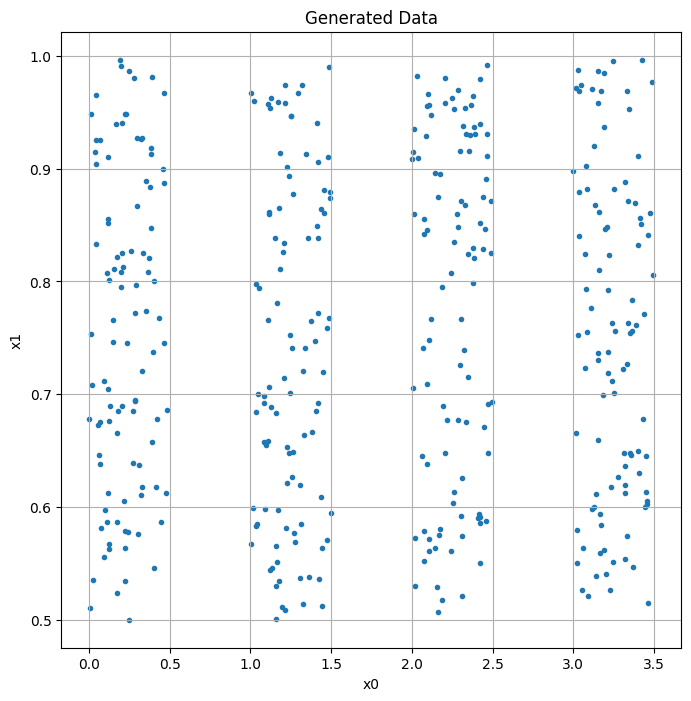

In [199]:
fig = plt.figure(figsize = (8,8))

plt.scatter(X[:, 0], X[:, 1], marker='.')
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Generated Data')
plt.grid()
plt.show()

## Clustering Algorithms

### K Means Clustering

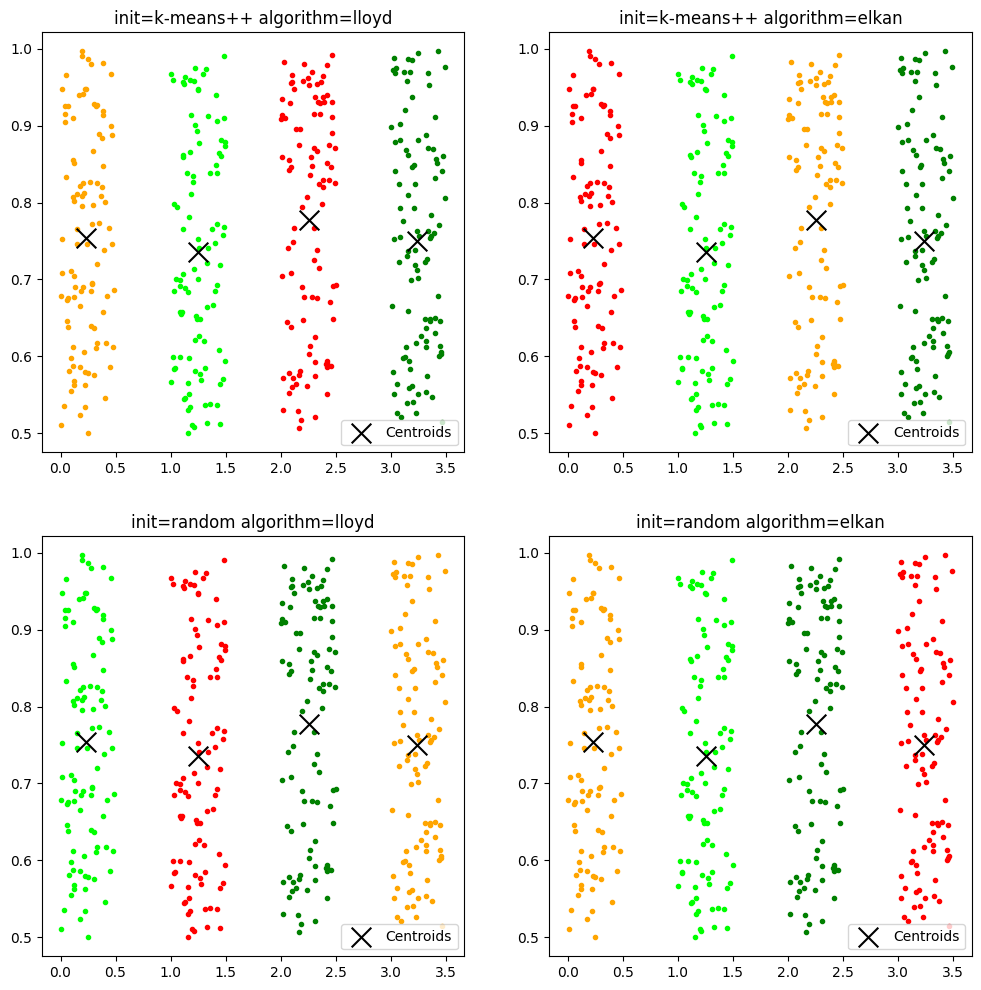

In [200]:
from sklearn.cluster import KMeans

init_array = ['k-means++', 'random']
algo_array = ['lloyd', 'elkan']

fig, axs = plt.subplots(len(init_array), len(algo_array), figsize=(fig_size * len(init_array), fig_size * len(algo_array)))

for i, init in enumerate(init_array):
    for j, algo in enumerate(algo_array):
        ax = axs[i, j]

        model = KMeans(n_clusters=classes, init=init, algorithm=algo, n_init='auto').fit(X)
        targ = model.predict(X)

        for idx, cl in enumerate(np.unique(targ)):
            ax.scatter(X[targ == cl, 0], X[targ == cl, 1], color=colors[idx], marker='.')

        centroids = model.cluster_centers_
        ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, c='black', label='Centroids')
        ax.legend()
        ax.set_title(f"init={init} algorithm={algo}")
plt.show()

### Fuzzy C-Means Clustering

                0             1             2             3
0    1.578570e-06  1.011139e-08  5.023278e-10  9.999984e-01
1    2.845264e-08  1.718597e-10  8.350856e-12  1.000000e+00
2    1.792791e-06  1.150414e-08  5.718250e-10  9.999982e-01
3    5.029350e-07  3.987946e-09  2.106159e-10  9.999995e-01
4    1.992621e-06  7.055412e-09  2.748834e-10  9.999980e-01
..            ...           ...           ...           ...
395  2.693684e-11  1.113678e-08  1.000000e+00  8.579427e-13
396  1.715248e-11  3.386571e-09  1.000000e+00  6.979863e-13
397  1.042542e-07  4.524632e-05  9.999546e-01  3.282322e-09
398  7.261327e-11  2.447244e-08  1.000000e+00  2.492373e-12
399  3.960553e-09  5.893671e-07  9.999994e-01  1.765937e-10

[400 rows x 4 columns]


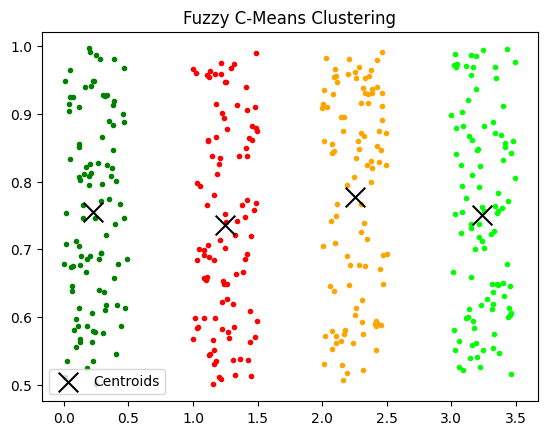

In [201]:
from skfuzzy import cmeans, cmeans_predict

c_means, u, u0, d, jm, p, fpc = cmeans(data = X.T, c = classes, m = 1.25, error = 0.05, maxiter = 1000)
target2 = np.argmax(u, axis=0)

for idx, cl in enumerate(np.unique(target2)):
    plt.scatter(X[target2 == cl, 0], X[target2 == cl, 1], color=colors[idx], marker='.')
    
plt.scatter(c_means[:, 0], c_means[:, 1], marker='x', s=200, c='black', label='Centroids')
plt.legend()
plt.title("Fuzzy C-Means Clustering")
print(pd.DataFrame(u.T))

### Spectral Clustering

c:\Users\PC 05\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


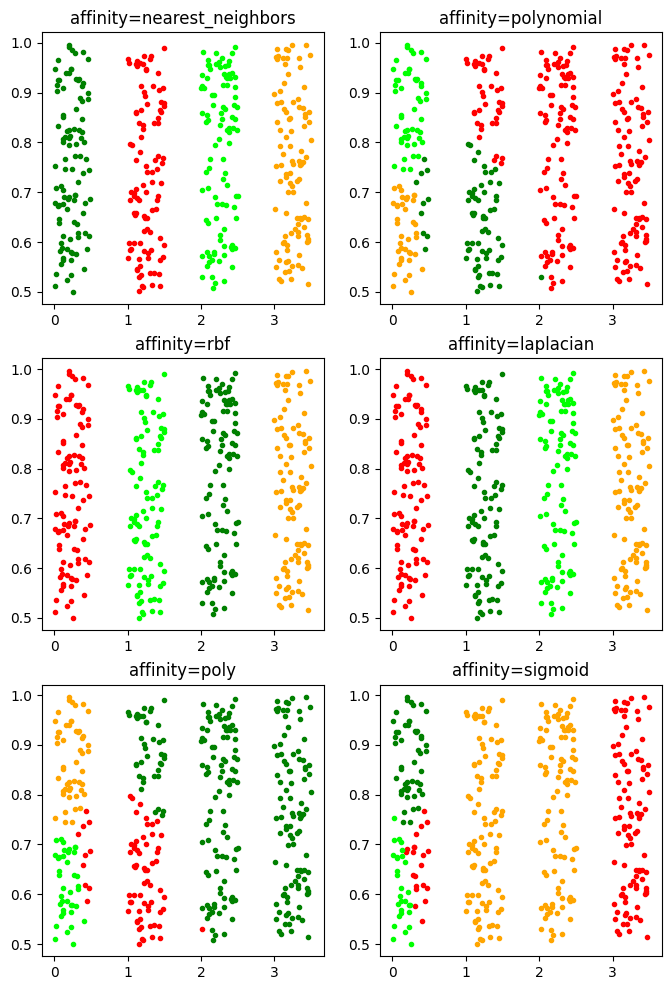

In [202]:
from sklearn.cluster import SpectralClustering

aff_array = ['nearest_neighbors', 'rbf', 'poly', 
                'polynomial', 'laplacian', 'sigmoid']
# you can use these kernels for affinity but they dont always work
# ['additive_chi2', 'chi2', 'linear', 'cosine']

fig, axs = plt.subplots(3, 2, figsize=(8, 12))

for i, aff in enumerate(aff_array):
    m = int(i / (len(aff_array) / 2))
    n = int(i % (len(aff_array) / 2))
    ax = axs[n, m]

    targ = SpectralClustering(n_clusters=classes, affinity=aff, gamma=0.5).fit_predict(X)

    for idx, cl in enumerate(np.unique(targ)):
        ax.scatter(X[targ == cl, 0], X[targ == cl, 1], color=colors[idx], marker='.')
        ax.set_title(f"affinity={aff}")
plt.show()

### Agglomerative Clustering

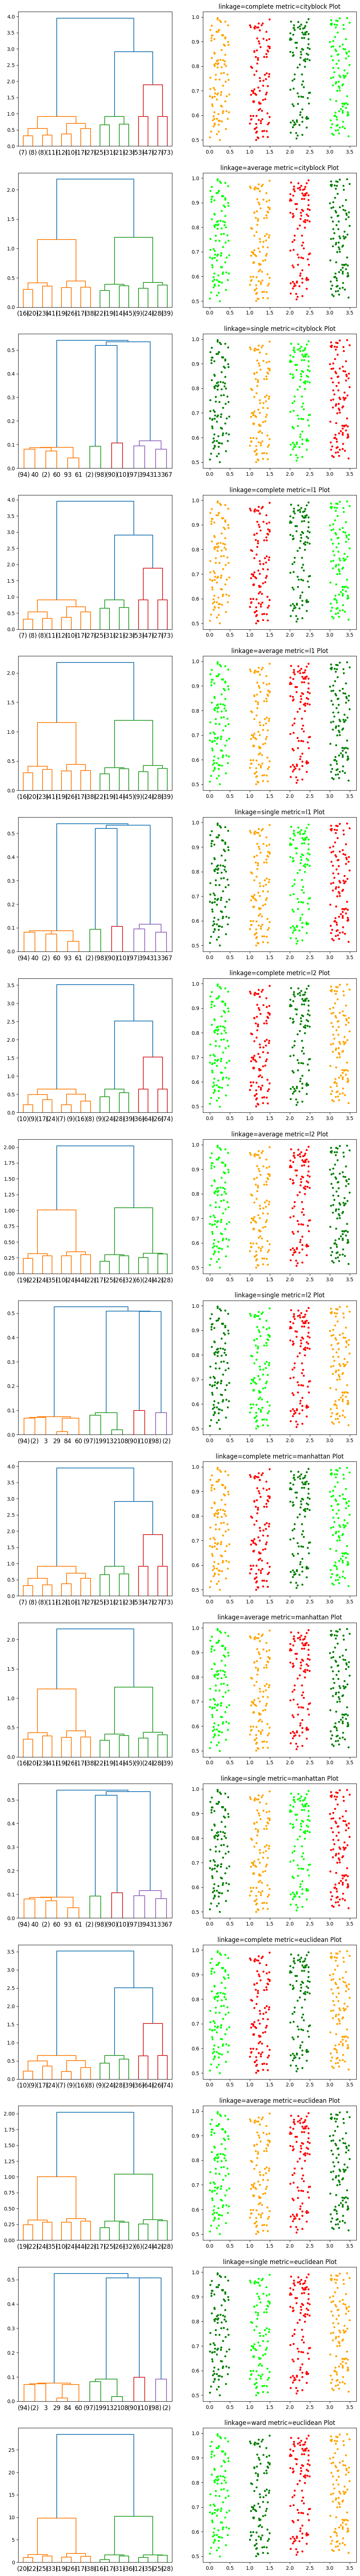

In [203]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

def plot_data(model, lin, met, ax):
    model.set_params(n_clusters=classes, distance_threshold=None)
    targ = model.fit_predict(X)
    for idx, cl in enumerate(np.unique(targ)):
        ax.scatter(X[targ == cl, 0], X[targ == cl, 1], color=colors[idx], marker='.')
        ax.set_title(f"linkage={lin} metric={met} Plot")

met_array = ['cityblock', 'l1', 'l2', 'manhattan', 'euclidean']
lin_array = ['complete', 'average', 'single'] # 'ward' only works on euclidian thus it is appended only in the end

fig, axs = plt.subplots(len(lin_array) * len(met_array) + 1, 2, figsize=(fig_size * 2, fig_size * len(lin_array) * len(met_array) + 1))

m = 0
for i, met in enumerate(met_array):
    if(met == 'euclidean'):
        lin_array.append('ward')
    for j, lin in enumerate(lin_array):
        model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=lin, metric=met)
        model = model.fit(X)

        plot_dendrogram(model, truncate_mode="level", p=3, ax=axs[m, 0])
        plot_data(model, lin, met, ax=axs[m, 1])
        m = m + 1

plt.show()

## References